In [1]:
# 1. Imports
import pandas as pd
import zipfile
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 2. Load data
with zipfile.ZipFile("C:/Users/zhaos/Downloads/archive (1).zip", 'r') as zip_ref:
    zip_ref.extractall("C:/Users/zhaos/Downloads/twitter_data")

train_df = pd.read_csv("C:/Users/zhaos/Downloads/twitter_data/twitter_training.csv", header=None, names=["Tweet ID", "Entity", "Sentiment", "Content"])
val_df = pd.read_csv("C:/Users/zhaos/Downloads/twitter_data/twitter_validation.csv", header=None, names=["Tweet ID", "Entity", "Sentiment", "Content"])

# 3. Filter for known sentiments and drop missing
def normalize_sentiment(sent):
    return sent if sent in ["Positive", "Negative", "Neutral", "Irrelevant"] else "Neutral"

train_df["Sentiment"] = train_df["Sentiment"].apply(normalize_sentiment)
val_df["Sentiment"] = val_df["Sentiment"].apply(normalize_sentiment)

train_df.dropna(subset=["Content", "Sentiment"], inplace=True)
val_df.dropna(subset=["Content", "Sentiment"], inplace=True)



In [2]:
# 4. Preprocess text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)     # remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)                   # remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)                     # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()                # remove extra spaces
    return text


train_df["Content"] = train_df["Content"].apply(clean_text)
val_df["Content"] = val_df["Content"].apply(clean_text)



In [3]:
# 5. Vectorize
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),         # includes unigrams and bigrams
    max_features=10000,
    stop_words='english'        # removes common filler words like "the", "and"
)

X_train = vectorizer.fit_transform(train_df["Content"])
X_val = vectorizer.transform(val_df["Content"])
y_train = train_df["Sentiment"]
y_val = val_df["Sentiment"]



In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define parameter grid
params = {"C": [0.1, 1, 5]}

# Grid search with liblinear solver and more iterations
clf = GridSearchCV(
    LogisticRegression(
        max_iter=1000,
        solver='liblinear',
        class_weight='balanced'  # optional, helps with class imbalance
    ),
    param_grid=params,
    cv=3,
    verbose=1,
    n_jobs=-1  # uses all CPU cores
)

# Fit the model
clf.fit(X_train, y_train)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, solver='liblinear'),
             n_jobs=-1, param_grid={'C': [0.1, 1, 5]}, verbose=1)

In [5]:
# 7. Evaluate
y_pred = clf.predict(X_val)
print("Best Params:", clf.best_params_)
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

Best Params: {'C': 0.1}

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.67      0.64      0.66       172
    Negative       0.67      0.78      0.72       266
     Neutral       0.74      0.60      0.66       285
    Positive       0.73      0.78      0.76       277

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.71      0.70      0.70      1000

Accuracy: 0.705


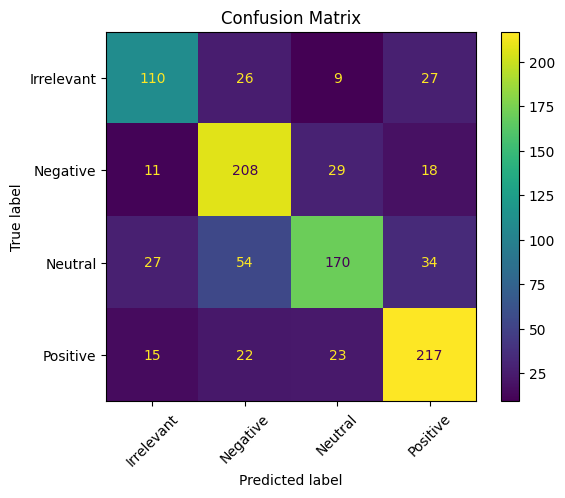

In [6]:
# 8. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [7]:
# 9. Most Informative Features
feature_names = vectorizer.get_feature_names_out()
coefs = clf.best_estimator_.coef_
classes = clf.best_estimator_.classes_

print("\nTop Informative Features per Class:")
for idx, label in enumerate(classes):
    top10 = coefs[idx].argsort()[-10:][::-1]
    print(f"\n{label}:")
    for i in top10:
        print(f"  {feature_names[i]}")


Top Informative Features per Class:

Irrelevant:
  player
  occurred
  people
  details
  team
  community
  guy
  hes
  tweet
  ban

Negative:
  fix
  fuck
  servers
  shit
  game
  sucks
  eamaddennfl
  wtf
  trash
  worst

Neutral:
  amazon
  johnson
  check
  com
  earned
  ranked
  facebook
  google
  just earned
  achievement

Positive:
  love
  fun
  wait
  excited
  nice
  wow
  thank
  amazing
  awesome
  good


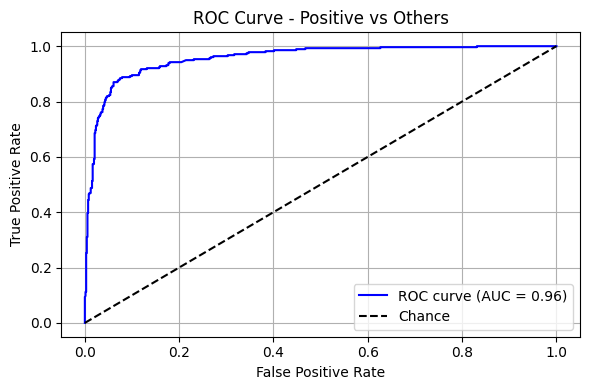

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert to binary labels: Positive = 1, Others = 0
y_train_binary = (y_train == "Positive").astype(int)
y_val_binary = (y_val == "Positive").astype(int)

# Train binary model
clf_bin = LogisticRegression(max_iter=200)
clf_bin.fit(X_train, y_train_binary)
y_score = clf_bin.decision_function(X_val)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_val_binary, y_score)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Positive vs Others')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
pip install transformers datasets torch scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

# === 1. Reduce your dataset === #
# (Assumes train_df and val_df are already loaded and cleaned)
train_df_small = train_df.sample(n=500, random_state=42)
val_df_small = val_df.sample(n=100, random_state=42)

# === 2. Encode sentiment labels === #
label_encoder = LabelEncoder()
train_df_small["label"] = label_encoder.fit_transform(train_df_small["Sentiment"])
val_df_small["label"] = label_encoder.transform(val_df_small["Sentiment"])

# === 3. Load tokenizer === #
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# === 4. Custom Dataset Class === #
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encodings["input_ids"].squeeze(0),
            "attention_mask": encodings["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# === 5. Create PyTorch Datasets and DataLoaders === #
train_dataset = TweetDataset(train_df_small["Content"].tolist(), train_df_small["label"].tolist(), tokenizer)
val_dataset = TweetDataset(val_df_small["Content"].tolist(), val_df_small["label"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# === 6. Load Pretrained Model === #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))
model.to(device)

# === 7. Optimizer === #
optimizer = AdamW(model.parameters(), lr=2e-5)

# === 8. Training Loop (Fast, Just 2 Epochs) === #
for epoch in range(2):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Training Loss: {total_loss:.4f}")

# === 9. Evaluation === #
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === 10. Metrics === #
print("✅ Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Training Loss: 43.7409
Epoch 2 | Training Loss: 41.1392
✅ Accuracy: 0.43
              precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00        16
    Negative       0.57      0.50      0.53        24
     Neutral       0.42      0.50      0.46        26
    Positive       0.38      0.53      0.44        34

    accuracy                           0.43       100
   macro avg       0.34      0.38      0.36       100
weighted avg       0.38      0.43      0.40       100



In [11]:
cd "C:\\Graduate courses\\s2\\Gen AI"

C:\Graduate courses\s2\Gen AI


In [14]:
# After your training and evaluation code, add these lines:

# Create directory for model
import os
os.makedirs("./model", exist_ok=True)

# Save the model and tokenizer
model.save_pretrained("./model")
tokenizer.save_pretrained("./model")

print("✅ Model and tokenizer saved successfully!")

✅ Model and tokenizer saved successfully!


In [15]:
model.save_pretrained("sentiment_model")
tokenizer.save_pretrained("sentiment_model")


('sentiment_model\\tokenizer_config.json',
 'sentiment_model\\special_tokens_map.json',
 'sentiment_model\\vocab.txt',
 'sentiment_model\\added_tokens.json',
 'sentiment_model\\tokenizer.json')